# attention and transformer

导入需要的包

In [1]:
import torch
from torch import nn
import math
from d2l import torch as d2l

## masked_softmax

如果有一个行向量，有效长度为l，要将l以后的值都替换为value，看看如何用代码实现

In [2]:
v = torch.randn(10) # 随机一个长度为10的向量
v

tensor([-1.2011,  0.0430, -1.4262, -1.0809, -0.7356, -0.5314,  0.6148, -0.0767,
         0.2123, -0.2471])

若l为7，则我现在需要一个`mask`，值为[false, false, ... ,true, true,...,true]，7以后的位置都为`true`

In [3]:
pos = torch.arange(len(v))
pos

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [4]:
mask = pos >= 7
mask

tensor([False, False, False, False, False, False, False,  True,  True,  True])

In [5]:
v[mask] = 1e-6
v

tensor([-1.2011e+00,  4.3009e-02, -1.4262e+00, -1.0809e+00, -7.3564e-01,
        -5.3137e-01,  6.1477e-01,  1.0000e-06,  1.0000e-06,  1.0000e-06])

到这里就实现了给一个行向量做mask的功能，接下来看看如果要批量做mask操作要如何实现。有一个矩阵v，每一行为一个向量，要按行来做mask操作

In [6]:
n, l = 5, 8
v = torch.ones(n,l)
lens = torch.arange(1, n+1)
v,lens

(tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.]]),
 tensor([1, 2, 3, 4, 5]))

看看pytorch的增加维度的机制

In [7]:
lens[None,:],lens[:,None]

(tensor([[1, 2, 3, 4, 5]]),
 tensor([[1],
         [2],
         [3],
         [4],
         [5]]))

利用广播机制可以得到mask

In [8]:
pos = torch.arange(v.shape[-1])
pos

tensor([0, 1, 2, 3, 4, 5, 6, 7])

In [9]:
mask = pos[None,:] >= lens[:,None]
mask

tensor([[False,  True,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True,  True],
        [False, False, False, False,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True]])

最后直接使用`mask`来赋值即可

In [10]:
v[mask] = -1
v

tensor([[ 1., -1., -1., -1., -1., -1., -1., -1.],
        [ 1.,  1., -1., -1., -1., -1., -1., -1.],
        [ 1.,  1.,  1., -1., -1., -1., -1., -1.],
        [ 1.,  1.,  1.,  1., -1., -1., -1., -1.],
        [ 1.,  1.,  1.,  1.,  1., -1., -1., -1.]])

接下来编写通用的`masked_softmax`，假设现在输入X形状为(b, q, k)，每个元素为attention score
- b: batch size
- q: 每个batch有q个query
- k: 每个q询问k个key
还有一个输入为valid_lens，形状可以是(b, q)，每个位置存着该query对应的有效k数量
- b: batch size
- q: query数
若valid_lens为(b)
则每个batch中所有q共享一个len

In [11]:
def masked_softmax(X, lens=None):
    def _sequence_mask(X, lens, value=0):
        # X: (n, L)
        # lens: (n) valid len of eche row
        # 该函数的实现就是按照上面的步骤来
        maxLen = X.shape[-1]
        mask = torch.arange(maxLen, device=X.device)[None,:] >= lens[:,None]
        X[mask] = value
        return X
        
    if lens is None:
        return torch.nn.functional.softmax(X,dim=-1)
    
    shapeX = X.shape
    if lens.dim() == 1:
        lens = torch.repeat_interleave(lens, shapeX[1])
    lens = lens.reshape(-1)
    X = _sequence_mask(X.reshape(-1,shapeX[-1]),lens, -1e6)
    return torch.nn.functional.softmax(X.reshape(shapeX),dim=-1)
    
    
X = torch.ones(2,3,4)
X

tensor([[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]])

In [12]:
lens = torch.tensor([[1,2,3],[4,1,2]])
X = masked_softmax(X, lens)
X

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.5000, 0.5000, 0.0000, 0.0000],
         [0.3333, 0.3333, 0.3333, 0.0000]],

        [[0.2500, 0.2500, 0.2500, 0.2500],
         [1.0000, 0.0000, 0.0000, 0.0000],
         [0.5000, 0.5000, 0.0000, 0.0000]]])

In [13]:
X = torch.ones(2,3,4)
lens = torch.tensor([1,4])
X = masked_softmax(X, lens)
X

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000, 0.0000]],

        [[0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500]]])

## 实现Scaled Dot Product Attention

给定$m$个$q$，记作$Q\in \mathbb{R}^{m\times d}$，同时给定$n$个$k$和$v$，分别记作$K\in \mathbb{R}^{n\times d}$和$V\in \mathbb{R}^{n\times v}$
$$
attention(K,Q,V)=softmax(\frac{QK^T}{\sqrt{d}})V
$$

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC Regular, 思源等宽, 黑体, Noto Serif CJK SC, 思源宋体, Noto Sans Mono CJK SC Regularsans-serif


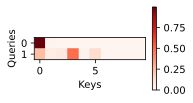

In [14]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, Qs, Ks, Vs, valid_lens = None):
        # 这里的Qs是多个batch的Q叠在一起，维度为(b, m, d)
        # Ks和Vs同理
        d = Qs.size(-1)
        scores = torch.bmm(Qs, Ks.transpose(-2,-1)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), Vs)
    
    
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])
attention = DotProductAttention(dropout=0.5)
attention.eval()
res = attention(queries, keys, values, valid_lens), (2, 1, 4)
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## Multi-Head Attention